# Nonlinear dynamics example

This example looks at uncertainty propagation and inverse learning for a highly nonlinear single degree of freedom system represented by a Bouc-Wen model of hysteresis:
\begin{align*}
& m \ddot{x}(t) + c \dot{x}(t) + k r(t) = - \ddot{u} \\
& \dot{r}(t) = \dot{x} - \beta \vert\dot{x}(t)\vert \vert r(t) \vert^{n-1} r(t) - \gamma \dot{x}(t) \vert r(t) \vert^{n}
\end{align*}
<br>
Stochasticity can arise from two distinct sources:
- stochasticity of the input excitation $u(t)$ (part 1), 
- uncertain (or random) set of parameters characteriwing the system (parts 2, 3, 4). 
In this context, the system is parameterized by the parameter vector
\begin{equation*}
\theta=\lbrace k, \delta^{+}, \delta^{-}, n, c \rbrace
\end{equation*}
where $\delta^{+}=\beta+\gamma$, $\delta^{-}=\beta-\gamma$; all parameters are non-negative and $n>1$ (this reparameterization using $\delta^{+, -}$ allows to easily guarantee the constraint $\beta > \gamma$).

This notebook illustrates the usage of various modules of UQpy to perform several UQ tasks with respect to this system, in particular: <br>
- RunModel module (all parts), <br>
- simulation of stochastic processes and forward propagation (part 1), <br>
- simulation of random variables and forward propagation (part 2), <br>
- Inference module (part 3), <br>
- Reliability module (part 4). <br>

The equations that allow forward simulation of the model are written in the python script utils_dynamics.py. The following cells show the behavior of the model for a given input (El-Centro earthquake ground motion) and a given set of parameters $\theta$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

[0.000e+00 2.000e-02 4.000e-02 ... 3.114e+01 3.116e+01 3.118e+01]


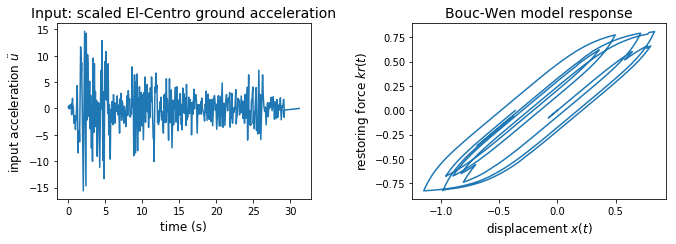

In [13]:
from scipy.integrate import solve_ivp
from functools import partial
from utils_dynamics import read_elcentro, deriv_sdof_boucwen

# Read data from El-Centro Earthquake
time_vec, accel = read_elcentro(scale=5.)
print(time_vec)
# Set a parameter value (k, beta+gamma, beta-gamma, n, c)
params = np.array([1.0, 2.0, 4.0, 4.0, 0.02])
# Solve ODE forward in time
fun = partial(deriv_sdof_boucwen, params=params, input_acceleration=accel, time_vec=time_vec)
sol = solve_ivp(fun, y0=[0., 0., 0.], t_span=[time_vec[0], time_vec[-1]], t_eval=time_vec)

# Plot excitation and solution (displacement - force plot)
fig, ax = plt.subplots(ncols=2, figsize=(9.5, 3.5))
ax[0].plot(time_vec, accel)
ax[0].set_xlabel('time (s)', fontsize=12)
ax[0].set_ylabel('input acceleration $\ddot{u}$', fontsize=12)
ax[0].set_title('Input: scaled El-Centro ground acceleration', fontsize=14)
ax[1].plot(sol.y[0, :], params[0] * sol.y[2, :])
ax[1].set_xlabel('displacement $x(t)$', fontsize=12) 
ax[1].set_ylabel(r'restoring force $k r(t)$', fontsize=12); 
ax[1].set_title('Bouc-Wen model response', fontsize=14)
fig.tight_layout()
plt.show(fig)

# Part 1: Define the Models via RunModel

### First model: uncertainties originate from stochasticity of the input excitation F(t)

In the UQpy framework, the user defines the deterministic forward model QoI=h(q) via the RunModel module. In the following, the QoI consists in the displacement time series of the Bouc-Wen SDOF system with a fixed set of parameters. The stochastic input q is the stochastic force vector (high dimensional random input).

In [9]:
T = 100  # Total time
nt = 256  # Num of Discretized Time
dt = T / nt
time_vec = np.linspace(0, T - dt, nt)   # time vector (same length as stochastic excitation)

from UQpy.RunModel import RunModel
dyn_model_SE = RunModel(model_script='utils_dynamics.py', model_object_name='sdof_boucwen_SE', ntasks=1, 
                        time_vec=time_vec, qoi_type='time_series')

### Second model: consider randomness in the system parameters $k, \delta^{+}, \delta^{-}, n$.

In [10]:
scale_factor = 50.
dyn_model_RP = RunModel(model_script='utils_dynamics.py', model_object_name='sdof_boucwen_RP', ntasks=4, 
                        scale_factor=scale_factor, qoi_type='time_series')

In [11]:
samples = np.array([1.0, 2.0, 4.0, 3.0]).reshape((1, 4))
dyn_model_RP.run(samples=samples)
qoi = dyn_model_RP.qoi_list[0]

# Part 2: Behavior of the nonlinear model to stochastic excitations

In the following section, the nonlinear SDOF is subjected to a stochastic excitation. Realizations of the stochastic process are sampled with the Spectral Representation Method, using the StochasticProcess module of UQpy.

### Generate realizations of a 1D-1V stochastic process

In [4]:
# Set some required constants
F = 1 / T * nt / 2  # Frequency.(Hz)
nw = 128  # Num of Discretized Freq.
dw = F / nw
t_u = 2*np.pi/2/F
if dt>t_u:
    print('Error (aliasing)')

# Generation of Input Data(Stationary)
t = np.linspace(0, T - dt, nt)
w = np.linspace(0, F - dw, nw)

# Compute the power spectral density S(w) at various points frequencies w
S = 125 / 4 * w ** 2 * np.exp(-5 * w)

In [5]:
# Sample 1000 realizations of the stochastic process
n_sim = 10

from UQpy.StochasticProcess import SRM
SRM_object = SRM(n_sim, S=S, dw=dw, nt=nt, nw=nw, case='uni')

### Propagate uncertainties via the RunModel module

In [6]:
# Run the model and plot results for one given run
T = 100  # Total time
nt = 256  # Num of Discretized Time
dt = T / nt
time_vec = np.linspace(0, T - dt, nt)
params = np.array([1.0, 2.0, 4.0, 3.0, 0.02])

dyn_model_SI = RunModel(samples=SRM_object.samples, ntasks=1, model_script='utils_dynamics.py',
             model_object_name='sdof_boucwen', params=params, time_vec=time_vec, qoi_type='time_series')

TypeError: sdof_boucwen() got multiple values for argument 'params'

In [7]:
m.run(samples=SRM_object.samples)
print(len(m.samples))
print(len(m.qoi_list))

20
20


In [8]:
m.run(samples=SRM_object.samples, append_samples=False)
print(len(m.samples))
print(len(m.qoi_list))

10
10


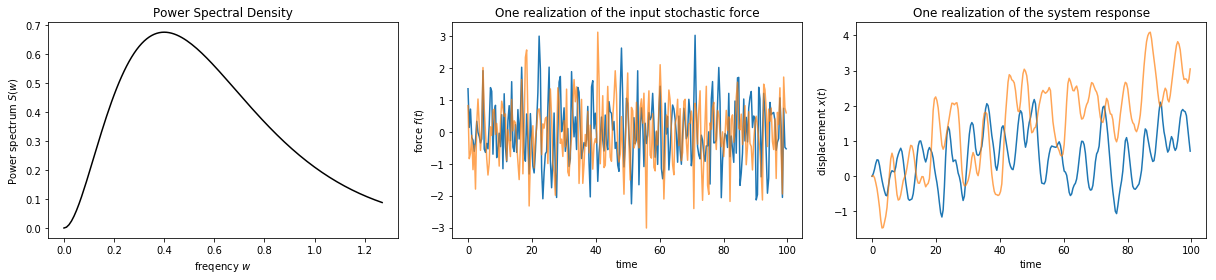

In [9]:
# Plots: power spectrum of the stochastic input, realizations of the input and model's behavior
fig, ax = plt.subplots(ncols=3, figsize=(17, 4))
ax[0].plot(w, S, color='black')
ax[0].set_xlabel('freqency $w$'); ax[0].set_ylabel('Power spectrum $S(w)$')
ax[0].set_title('Power Spectral Density')
for j in range(2):
    ax[1].plot(t, SRM_object.samples[j], alpha=1.-j*0.3)
    ax[1].set_xlabel('time'); ax[1].set_ylabel('force $f(t)$')
    ax[1].set_title('One realization of the input stochastic force')
    ax[2].plot(t, m.qoi_list[j], alpha=1.-j*0.3)
    ax[2].set_xlabel('time'); ax[2].set_ylabel('displacement $x(t)$')
    ax[2].set_title('One realization of the system response')
fig.tight_layout()
plt.show(fig)

# Part 2: Forward propagation of uncertainties in the model parameters

Set up the model via RunModel

In [ ]:
from UQpy.Distributions import Distribution
from UQpy.RunModel import RunModel
from UQpy.SampleMethods import MCS

### Set a distribution for the random parameters: $k, \delta^{+}, \delta^{-}, n$.

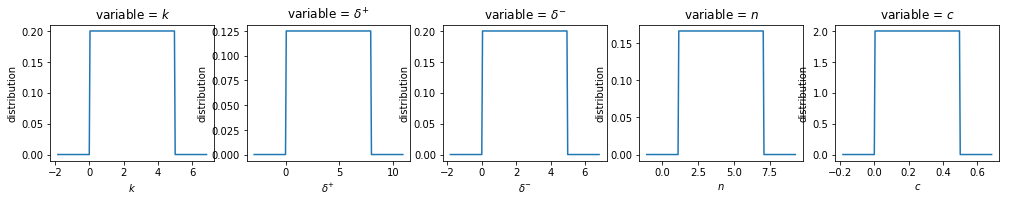

In [11]:
variables = ['$k$', '$\delta^{+}$', '$\delta^{-}$', '$n$', '$c$']
dist_names = ['uniform'] * 5
dist_params = [[0., 5.], [0., 8.], [0., 5.], [1.1, 6.], [0., 0.5]]
fig_prior, ax = plt.subplots(ncols=5, figsize=(17, 2.5))
for i, (var, name, params) in enumerate(zip(variables, dist_names, dist_params)):
    p = Distribution(name)
    mean, std = p.moments(params)[0], np.sqrt(p.moments(params)[1])
    domain = np.linspace(mean - 3 * std, mean + 3 * std, 200).reshape((-1, 1))
    ax[i].plot(domain, p.pdf(x=domain, params=params))
    ax[i].set_title('variable = '+var)
    ax[i].set_xlabel(var); ax[i].set_ylabel('distribution')
fig.tight_layout()
plt.show()

### Sample realizations using the MCS class

In [12]:
# Get samples
nsamples = 200
MCS_object = MCS(dist_name=dist_names, dist_params=dist_params, nsamples=nsamples)

TypeError: Input should be provided as a nested list of 2d ndarray of shape (nsamples, dimension).

### Propagate uncertainties via the RunModel module

In [ ]:
# Run the model and plot results for one given run
m = RunModel(samples=MCS_object.samples, ntasks=1, model_script='utils_dynamics.py', 
             model_object_name='sdof_boucwen_RP_50')
qois = [max(np.abs(disp)) for disp in m.qoi_list]

### Results: cobweb plot as a preliminary sensitivity study

In [ ]:
# Cobweb plot
sort_ind = np.argsort(qois)
tmp = np.array([np.append(MCS_object.samples[ind, :], qois[ind]) for ind in sort_ind])
mins, maxs = np.amin(tmp, axis=0, keepdims=True), np.amax(tmp, axis=0, keepdims=True)
print(mins)
print(maxs)
tmp = (tmp - mins) / (maxs - mins)
fig, ax = plt.subplots(figsize=(10, 5))
domain = list(range(mins.size))
for j, row in enumerate(tmp):
    if j >= len(tmp) / 1.1:
        ax.plot(domain, row, color='red')
    else:
        ax.plot(domain, row, color='green', alpha=0.2)
ax.get_yaxis().set_visible(False)
for edge in ['top', 'bottom', 'right', 'left']:
    ax.spines[edge].set_visible(False)
ax.text(x=5.1, y=0.9, s='failure', fontsize=14, color='red')
ax.set_xticks(domain)
ax.set_xticklabels(['min('+var+')' for var in variables]+['min(QoI)'], fontsize=12)
ax2 = ax.twiny()
for edge in ['top', 'bottom', 'right', 'left']:
    ax2.spines[edge].set_visible(False)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(domain)
ax2.set_xticklabels(['max('+var+')' for var in variables]+['max(QoI)'], fontsize=12)
ax2.set_xlabel('Cobweb plot: sensitivity of output QoI to input parameters', fontsize=14)
plt.show(fig)

# Part 3: Inference from data

### Generate synthetic noisy data

For the inference problem, i.e., parameter learning and model selection from data, it is assumed that the user has perfect knowledge of the input excitation and has access to noisy measurements of the system's displacement. The noisy data is generated synthetically using the Bouc-Wen model of hysteresis as the true model, and two cases are considered corresponding to two different levels of excitation. 5% rms gaussian noise is added to the measurements.

In [ ]:
from UQpy.Distributions import Distribution
from UQpy.RunModel import RunModel
from UQpy.Inference import Model, MLEstimation, BayesParameterEstimation, InfoModelSelection

In [ ]:
kwargs_model = {'ntasks': 1, 'model_script': 'utils_dynamics.py', 'model_object_name': 'sdof_boucwen_RP_50'}

In [ ]:
# Generate data
true_theta = np.array([1.0, 2.0, 4.0, 4.0, 0.02]).reshape((1, -1))
m = RunModel(samples=true_theta, **kwargs_model)
data = m.qoi_list[0].reshape((-1, ))
var_noise = (0.05 * np.sqrt(np.mean(data ** 2))) ** 2
data_noisy = data + Distribution('normal').rvs(params=[0., np.sqrt(var_noise)], nsamples=data.size).reshape((-1,))

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(data)
ax.plot(data_noisy, linestyle='none', marker='.')
plt.show()

## Inference for a single model: maximum-likelihood versus full Bayesian approach

In this case we assume that the model is known, and we learn the model parameters from data. The assumed known model is a Bouc-Wen model of hysteresis without viscous damping, i.e., $c=0$. There is thus a discrepancy (modeling error) between the true model used to generate the data and the model assumed for inference. This is enforced when defining the Model instance for Inference by setting only four parameters to be learnt and one fixed parameter set to 0. 

For the Bayesian analysis, a prior must also be defined within the model as follows.

### Define a prior and a probabilistic model for inference

In [ ]:
var_names = ['$k$', '$\delta^{+}$', '$\delta^{-}$', '$n$']#, '$c$']
prior_name = ['uniform'] * 4
prior_params = [[0., 3.], [0., 5.], [0., 3.], [1.1, 4.]]#, [0., 0.5]]

fig_prior, ax = plt.subplots(ncols=4, figsize=(15, 2.5))
for i, (var, name, params) in enumerate(zip(var_names, prior_name, prior_params)):
    p = Distribution(name)
    mean, std = p.moments(params)[0], np.sqrt(p.moments(params)[1])
    domain = np.linspace(mean - 3 * std, mean + 3 * std, 200)
    ax[i].plot(domain, p.pdf(x=domain, params=params))
    ax[i].set_title('variable = '+var)
    ax[i].set_xlabel(var); ax[i].set_ylabel('prior pdf')
fig.tight_layout()
plt.show()

In [ ]:
model_bw = Model(n_params=4, fixed_params=[0., ], model_type='python', error_covariance=var_noise, var_names=var_names,
                 prior_name=prior_name, prior_params=prior_params, **kwargs_model)

In [ ]:
print(model_bw.log_like(data=data_noisy, params=true_theta[:, :4]))
print(model_bw.log_like(data=data_noisy, 
                        params=np.array([1.09069616, 8.93219916, 2.15359081, 6.22293405]).reshape((1, -1))))

### Perform ML estimation and Bayesian inference

In [ ]:
# Set the initial guess as the mean of the prior distribution
x0 = [Distribution(name).moments(params)[0] for (name, params) in zip(prior_name, prior_params)]

In [ ]:
ml_estimator = MLEstimation(model=model_bw, data=data_noisy, iter_optim=3, x0=x0, method_optim='nelder-mead',
                            bounds=[(0., 3.), (0., 5.), (0., 3.), (1.05, 5.)])
print(ml_estimator.param)

In [ ]:
be = BayesParameterEstimation(data=data_noisy, model=model_bw, sampling_method='MCMC', nsamples=10000,
                              algorithm='MH', jump=1, nburn=0, pdf_proposal_type='Normal',
                              pdf_proposal_scale=[0.01, 0.01, 0.01, 0.01], seed=x0)
fig, ax = plt.subplots(ncols=4, figsize=(17, 4))
for i, param_name in enumerate(var_names):
    ax[i].plot(be.samples[:, i])
    ax[i].set_title('chain for '+param_name)

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(17, 4))
for i, param_name in enumerate(var_names):
    ax[i].hist(be.samples[:, i], density=True, bins=30)
    ax[i].set_title(param_name)
    ax[i].set_ylabel('posterior pdf')

## Comparison of various models via information theoretic criteria

In the following, three models are compared using the available noisy data:<br>
- a linear SDOF with viscous damping, <br>
- an elastoplastic SDOF with viscous damping, the nonlinear restoring force is $k x(t)$ if  $x(t)<x_{n}$, $0.$ otherwise, <br>
- a Bouc-Wen model of hysteresis without viscous damping. <br>

The capability of each model to represent the available data is assessed by computing an information theoretic criterion. The model that minimizes the criterion is the 'best' model given the data. Such analysis is performed within UQpy by calling the InfoModelSelection class of the Inference module.

# Part 4: Reliability

In [ ]:
# Generate data
true_theta = np.array([1.0, 2.0, 4.0, 5.0, 0.0]).reshape((1, -1))
m = RunModel(samples=true_theta, **kwargs_model)
data = m.qoi_list[0].reshape((-1, ))
var_noise = (0.05 * np.sqrt(np.mean(data_low ** 2))) ** 2
data_noisy = data + Distribution('normal').rvs(params=[0., np.sqrt(var_noise)], nsamples=data.size).reshape((-1,))

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(data)
ax.plot(data_noisy, linestyle='none', marker='.')
plt.show()

true_theta = np.array([1.09069616, 8.93219916, 2.15359081, 6.22293405, 0.0]).reshape((1, -1))
m = RunModel(samples=true_theta, **kwargs_model)
data = m.qoi_list[0].reshape((-1, ))
var_noise = (0.05 * np.sqrt(np.mean(data_low ** 2))) ** 2
data_noisy = data + Distribution('normal').rvs(params=[0., np.sqrt(var_noise)], nsamples=data.size).reshape((-1,))

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(data)
ax.plot(data_noisy, linestyle='none', marker='.')
plt.show()

# Part 4: Reliability 

In [ ]:
from UQpy.Distributions import Distribution
from UQpy.RunModel import RunModel
from UQpy.SampleMethods import MCS
from UQpy.Reliability import SubsetSimulation

In [ ]:
variables = ['$k$', '$\delta^{+}$', '$\delta^{-}$', '$n$', '$c$']
dist_names = ['uniform'] * 5
dist_params = [[0., 5.], [0., 8.], [0., 5.], [1.1, 6.], [0., 0.5]]
# Get samples
nsamples = 100000
MCS_object = MCS(dist_name=dist_names, dist_params=dist_params, nsamples=nsamples)
# # Run the model and plot results for one given run
m = RunModel(samples=MCS_object.samples, ntasks=1, model_script='utils_dynamics.py', 
             model_object_name='sdof_boucwen_RP_50_max')

In [ ]:
sorted_qois = np.sort(m.qoi_list)[::-1]
print(sorted_qois[99])

In [ ]:
## QoI : max dispalcenet

In [ ]:
## Run MCS for 100000 samples and estimate probability of failure - find QoI that leads to prob of 1e-3

In [ ]:
## SubSet Simulation